In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder,PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
encoder = LabelEncoder()
encoder.fit_transform(train['NObeyesdad'])

array([6, 1, 0, ..., 3, 6, 3])

In [4]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
print("Number of NaN values in train set:", train.isnull().sum().sum())
print("Number of NaN values in test set:", test.isnull().sum().sum())

Number of NaN values in train set: 0
Number of NaN values in test set: 0


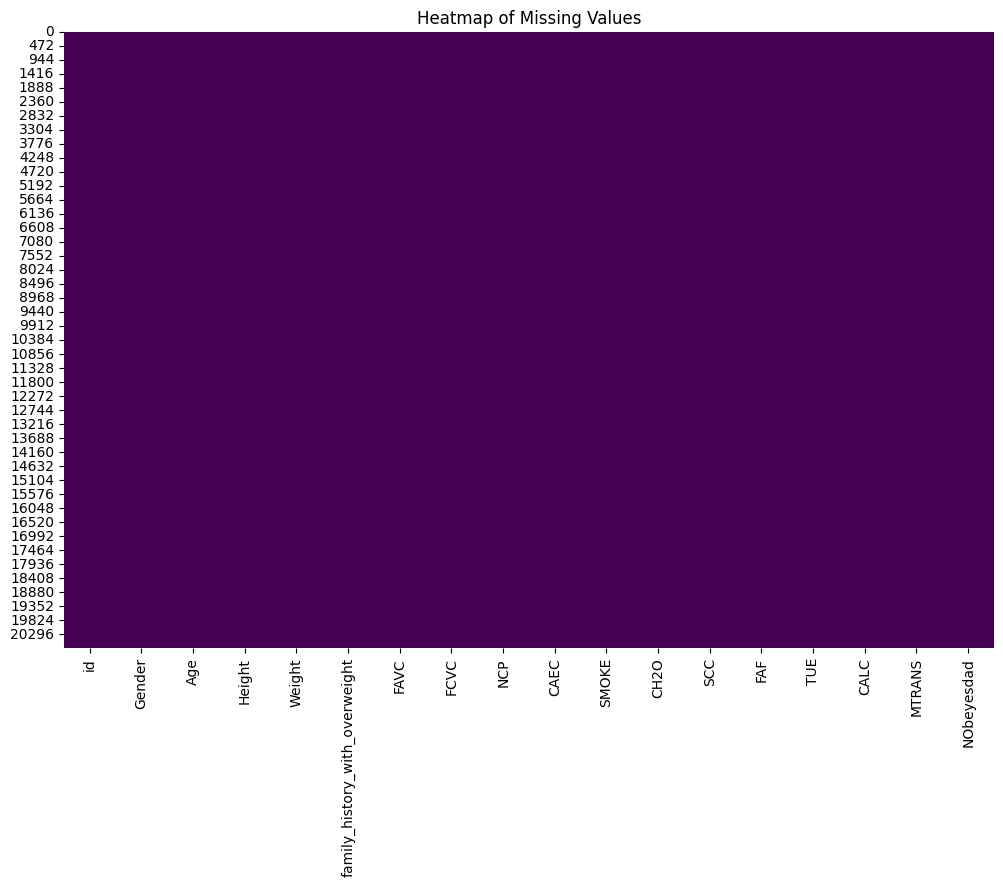

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.isnull(), cmap='viridis', cbar=False)

plt.title('Heatmap of Missing Values')
plt.show()

In [7]:
duplicates = train.duplicated()
print("Duplicates in training set: ", duplicates.sum())  # Number of duplicate rows
duplicates = test.duplicated()
print("Duplicates in test set: ", duplicates.sum())  # Number of duplicate rows

Duplicates in training set:  0
Duplicates in test set:  0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [9]:
train_id = train['id']
test_id = test['id']
y = train['NObeyesdad']

In [10]:
train.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [11]:
train_cat = train.select_dtypes(include='object')
train_num = train.select_dtypes(include='float64')
cat_columns = train_cat.columns
num_columns = train_num.columns

In [12]:
train_cat.describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,20758,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17014,18982,17529,20513,20071,15066,16687,4046


In [13]:
train_num.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [14]:
train['BMI'] = train['Weight'] / train['Height']**2
test['BMI'] = test['Weight'] / test['Height']**2

In [15]:
def transform_feats(data):
    data['Gender_binary'] = data['Gender'].map({'Male': 1, 'Female': 0}).astype(int)
    data['family_history_with_overweight_binary'] = data['family_history_with_overweight'].map({'yes': 1, 'no': 0}).astype(int)
    data['SMOKE_binary'] = data['SMOKE'].map({'yes': 1, 'no': 0}).astype(int)
    
    # taken from: https://www.kaggle.com/code/ravi20076/playgrounds4e02-extraftre-models
    data["CAEC"] = data["CAEC"].map({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3}).astype(np.uint8)
    data['SCC']  = np.where(data["SCC"] == "no", 1,0).astype(np.uint8)
    data["CALC"] = data["CALC"].map({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 2}).astype(np.uint8)
    return data

def feature_engineering(data):
    # BMI
    data['BMI'] = data['Weight'] / (data['Height'] ** 2)
    # Activity
    data['Activity'] = data['FAF'] * data['TUE']
    # Age group
    data['Age_Group'] = pd.cut(data['Age'], bins=[0, 18, 30, 45, float('inf')], labels=[0, 1, 2, 3])
    data['Age_Group'] = data['Age_Group'].astype(int)
    # Height group
    data['Height_Group'] = pd.cut(data['Height'], bins=[0, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, float('inf')], labels=[0, 1, 2, 3, 4, 5, 6])
    data['Height_Group'] = data['Height_Group'].astype(int)
    #Risk score    
    # taken from: https://www.kaggle.com/code/ravi20076/playgrounds4e02-extraftre-models
    data["BMIbyNCP"] = np.log1p(data["BMI"]) - np.log1p(data["NCP"])
    data["BMIFAF"] = (data["BMI"] * data["FAF"])/ 25.0
    data["FCVCpNCP"] = data['FCVC'] * data['NCP']
    return data
train = feature_engineering(train)
test = feature_engineering(test)

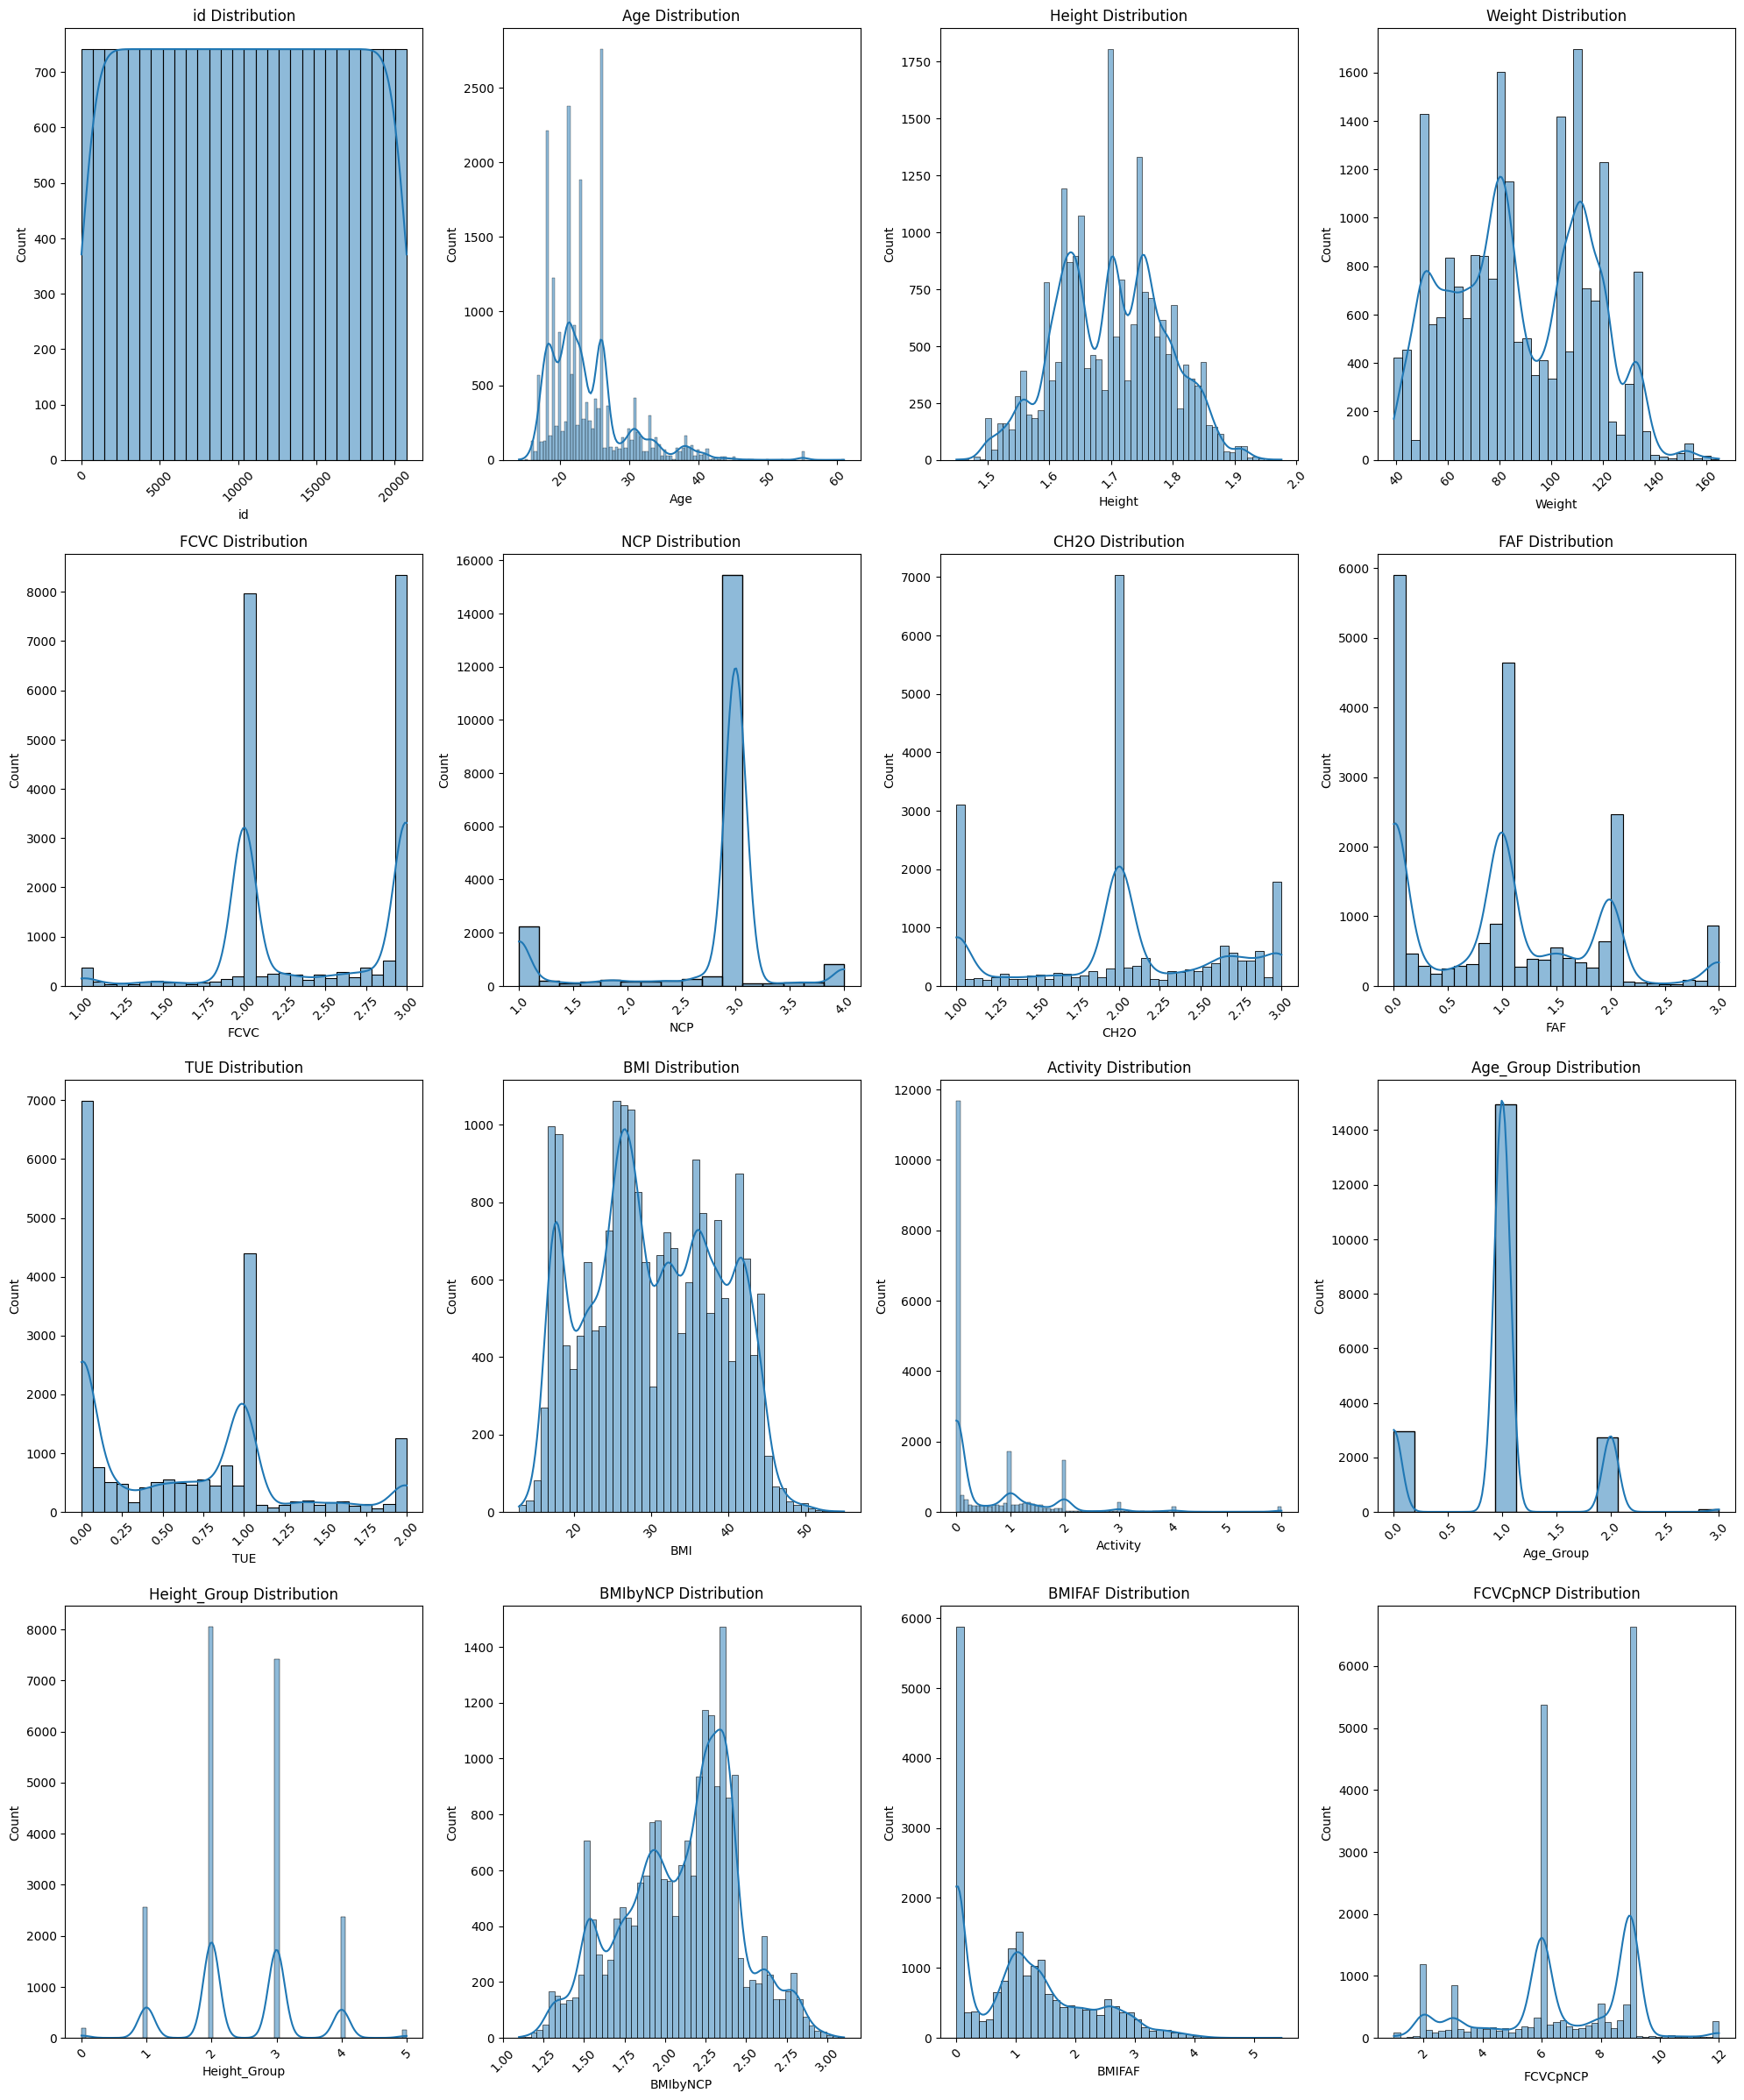

In [16]:
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
num_cols = len(numerical_columns)
num_rows = -(-num_cols // 4) 

plt.figure(figsize=(20, 6 * num_rows))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.histplot(train[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

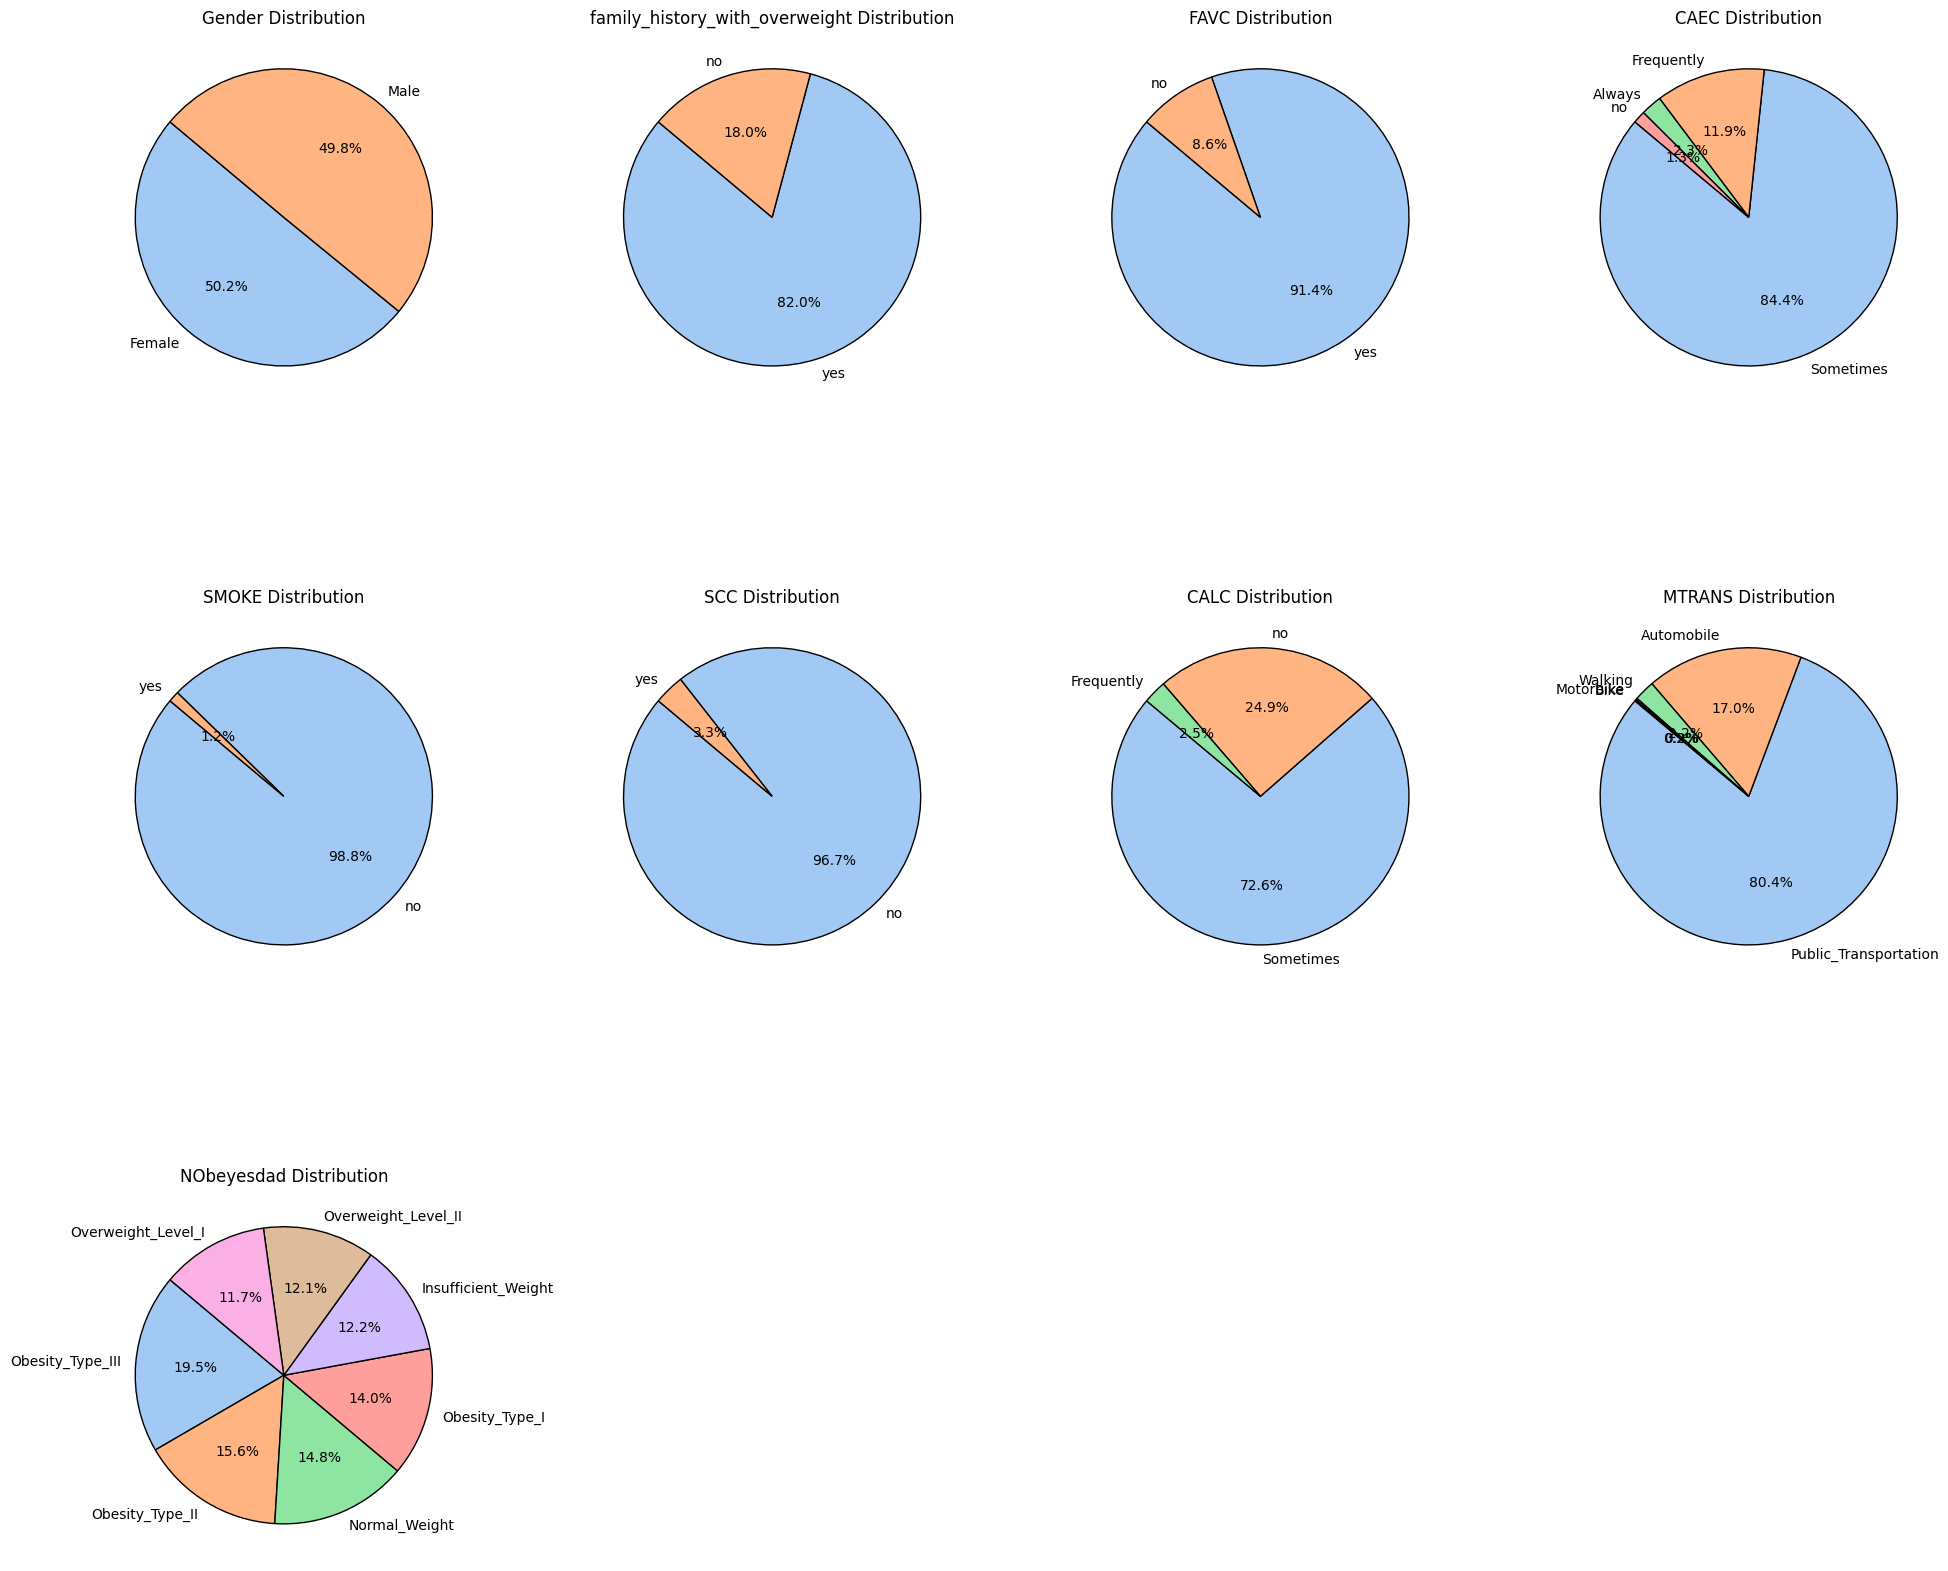

In [17]:
num_cols = len(categorical_columns)
num_rows = -(-num_cols // 4)

plt.figure(figsize=(20,6 *num_rows))
for i ,col in enumerate(categorical_columns,1):
    category_counts = train[col].value_counts()
    plt.subplot(num_rows, 4, i)
    colors = sns.color_palette('pastel')[0:len(category_counts)]
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops=dict(edgecolor='black', linewidth=1))
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout(pad=2)
plt.show()

In [18]:
columns=['Gender','family_history_with_overweight','FAVC','SMOKE','SCC']
train=pd.get_dummies(train,columns=columns,drop_first=True,dtype=int)
test=pd.get_dummies(test,columns=columns,drop_first=True,dtype=int)

In [19]:
train.nunique()

id                                    20758
Age                                    1703
Height                                 1833
Weight                                 1979
FCVC                                    934
NCP                                     689
CAEC                                      4
CH2O                                   1506
FAF                                    1360
TUE                                    1297
CALC                                      3
MTRANS                                    5
NObeyesdad                                7
BMI                                   12605
Activity                               6108
Age_Group                                 4
Height_Group                              6
BMIbyNCP                              13743
BMIFAF                                11488
FCVCpNCP                               3568
Gender_Male                               2
family_history_with_overweight_yes        2
FAVC_yes                        

In [20]:
le=LabelEncoder()
a=['CAEC','CALC','MTRANS']
for i in a:
    train[i]=le.fit_transform(train[i])
    test[i]=le.fit_transform(test[i])

In [21]:
train.head()

,id,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,...,Age_Group,Height_Group,BMIbyNCP,BMIFAF,FCVCpNCP,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2,2.763573,0.000000,0.976473,...,1,2,1.994097,0.000000,5.966594,1,1,1,0,0
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,1,2.000000,1.000000,1.000000,...,0,1,1.809194,0.936884,6.000000,0,1,1,0,0
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,2,1.910378,0.866045,1.673584,...,0,3,2.017061,0.593300,2.654722,0,1,1,0,0
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,2,1.674061,1.467863,0.780199,...,1,3,2.439207,2.633687,9.000000,0,1,1,0,0
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,2,1.979848,1.967973,0.931721,...,2,5,2.191822,2.015138,5.282883,1,1,1,0,0


In [22]:
test.head()

,id,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,...,Age_Group,Height_Group,BMIbyNCP,BMIFAF,FCVCpNCP,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes
0,20758,26.899886,1.848294,120.644178,2.938616,3.000000,2,2.825629,0.855400,0.000000,...,1,4,2.205948,1.208352,8.815848,1,1,1,0,0
1,20759,21.000000,1.600000,66.000000,2.000000,1.000000,2,3.000000,1.000000,0.000000,...,1,1,2.594555,1.031250,2.000000,0,1,1,0,0
2,20760,26.000000,1.643355,111.600553,3.000000,3.000000,2,2.621877,0.000000,0.250502,...,1,2,2.359063,0.000000,9.000000,0,1,1,0,0
3,20761,20.979254,1.553127,103.669116,2.000000,2.977909,2,2.786417,0.094851,0.000000,...,1,1,2.402909,0.163056,5.955818,1,1,1,0,0
4,20762,26.000000,1.627396,104.835346,3.000000,3.000000,2,2.653531,0.000000,0.741069,...,1,2,2.317083,0.000000,9.000000,0,1,1,0,0


In [23]:
train['NObeyesdad']

0        Overweight_Level_II
1              Normal_Weight
2        Insufficient_Weight
3           Obesity_Type_III
4        Overweight_Level_II
                ...         
20753        Obesity_Type_II
20754    Insufficient_Weight
20755        Obesity_Type_II
20756    Overweight_Level_II
20757        Obesity_Type_II
Name: NObeyesdad, Length: 20758, dtype: object

In [24]:
train['NObeyesdad']=le.fit_transform(train['NObeyesdad'])

In [25]:
train['NObeyesdad']

0        6
1        1
2        0
3        4
4        6
        ..
20753    3
20754    0
20755    3
20756    6
20757    3
Name: NObeyesdad, Length: 20758, dtype: int64

In [26]:
train.head()

,id,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,...,Age_Group,Height_Group,BMIbyNCP,BMIFAF,FCVCpNCP,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2,2.763573,0.000000,0.976473,...,1,2,1.994097,0.000000,5.966594,1,1,1,0,0
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,1,2.000000,1.000000,1.000000,...,0,1,1.809194,0.936884,6.000000,0,1,1,0,0
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,2,1.910378,0.866045,1.673584,...,0,3,2.017061,0.593300,2.654722,0,1,1,0,0
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,2,1.674061,1.467863,0.780199,...,1,3,2.439207,2.633687,9.000000,0,1,1,0,0
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,2,1.979848,1.967973,0.931721,...,2,5,2.191822,2.015138,5.282883,1,1,1,0,0


In [27]:
print(numerical_columns)

['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'Activity', 'Age_Group', 'Height_Group', 'BMIbyNCP', 'BMIFAF', 'FCVCpNCP']


In [28]:
train.drop('id', axis=1)
test.drop('id', axis=1)
train_features = train.drop('NObeyesdad', axis=1)
for col in ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'Activity', 'BMIbyNCP', 'BMIFAF', 'FCVCpNCP']:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

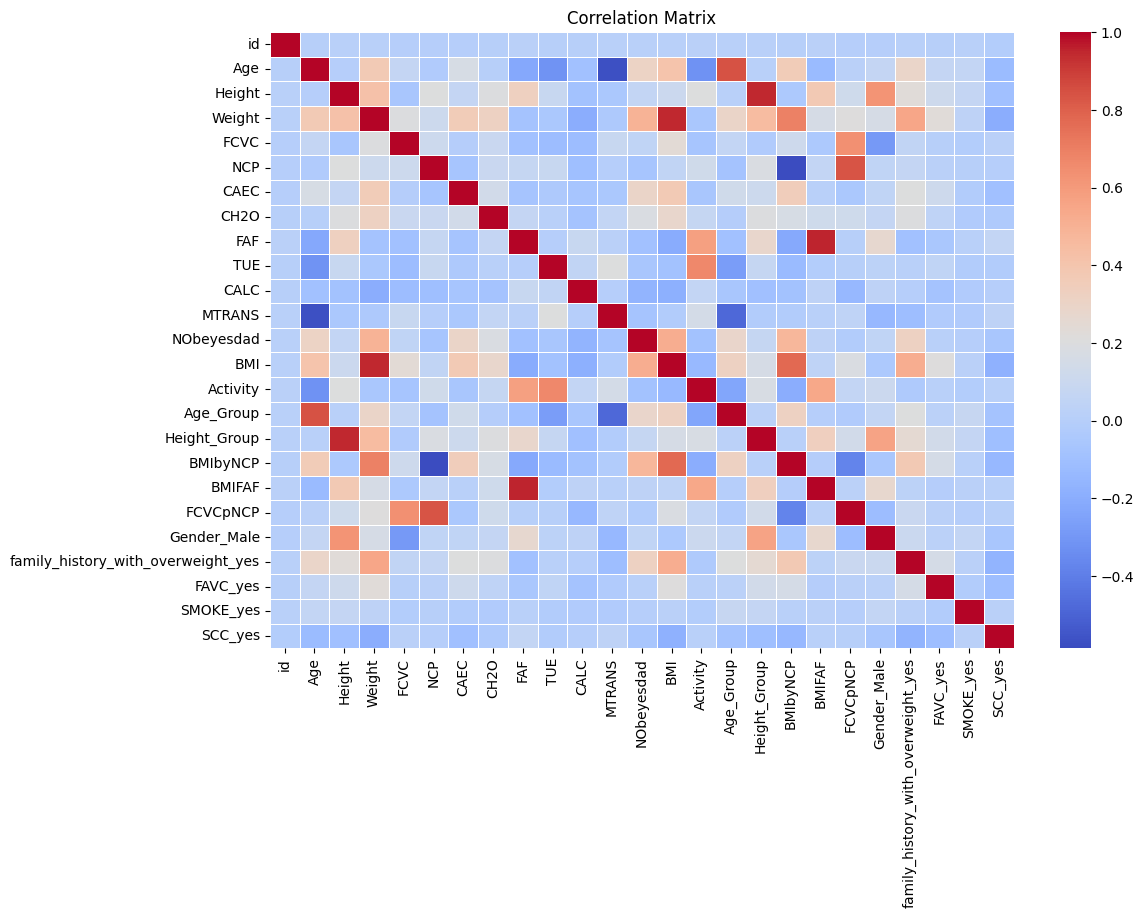

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [30]:
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data

train_scaled = remove_outliers(train)
test_scaled = remove_outliers(test)

In [31]:
y = train['NObeyesdad']
X = train.drop('NObeyesdad', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
test

,id,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,...,Age_Group,Height_Group,BMIbyNCP,BMIFAF,FCVCpNCP,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes
0,20758,3.328623,1.046720,4.801100,1.370829,1.386294,2,1.341723,0.618100,0.000000,...,1,4,1.165008,0.792247,2.283998,1,1,1,0,0
1,20759,3.091042,0.955511,4.204693,1.098612,0.693147,2,1.386294,0.693147,0.000000,...,1,1,1.279420,0.708651,1.098612,0,1,1,0,0
2,20760,3.295837,0.972049,4.723847,1.386294,1.386294,2,1.286992,0.000000,0.223545,...,1,2,1.211662,0.000000,2.302585,0,1,1,0,0
3,20761,3.090099,0.937319,4.650804,1.098612,1.380756,2,1.331420,0.090618,0.000000,...,1,1,1.224631,0.151051,1.939578,1,1,1,0,0
4,20762,3.295837,0.965993,4.661885,1.386294,1.386294,2,1.295694,0.000000,0.554499,...,1,2,1.199086,0.000000,2.302585,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,3.191621,1.001141,4.369832,1.338478,1.386294,2,0.693147,0.591710,0.575845,...,1,3,1.072206,0.615253,2.244924,1,1,0,0,0
13836,34594,3.401197,0.951658,4.143135,1.386294,1.386294,2,1.098612,0.000000,0.000000,...,1,1,1.048490,0.000000,2.302585,0,0,1,0,0
13837,34595,3.175367,0.949937,3.814997,1.386294,1.185933,1,1.098612,1.081751,0.693147,...,1,1,1.007967,0.865734,2.056841,0,0,1,0,0
13838,34596,3.091042,0.963174,3.988984,1.098612,1.386294,2,1.098612,1.386294,1.098612,...,1,2,0.981132,1.230637,1.945910,1,1,1,0,0


In [33]:
X_train.isnull().sum()

id                                    0
Age                                   0
Height                                0
Weight                                0
FCVC                                  0
NCP                                   0
CAEC                                  0
CH2O                                  0
FAF                                   0
TUE                                   0
CALC                                  0
MTRANS                                0
BMI                                   0
Activity                              0
Age_Group                             0
Height_Group                          0
BMIbyNCP                              0
BMIFAF                                0
FCVCpNCP                              0
Gender_Male                           0
family_history_with_overweight_yes    0
FAVC_yes                              0
SMOKE_yes                             0
SCC_yes                               0
dtype: int64

In [34]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1,
                              criterion='gini', bootstrap=True,
                             class_weight=None, ccp_alpha=0.0, max_samples=None)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [35]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.8966763005780347
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.93      0.93       524
           1       0.86      0.88      0.87       626
           2       0.88      0.87      0.88       543
           3       0.97      0.98      0.97       657
           4       1.00      1.00      1.00       804
           5       0.74      0.76      0.75       484
           6       0.81      0.79      0.80       514

    accuracy                           0.90      4152
   macro avg       0.89      0.88      0.89      4152
weighted avg       0.90      0.90      0.90      4152

Confusion Matrix: [[485  36   0   0   0   2   1]
 [ 29 549   0   0   0  46   2]
 [  2   1 473  12   1  19  35]
 [  0   0  15 641   0   0   1]
 [  0   0   1   1 802   0   0]
 [  1  46  11   0   0 367  59]
 [  0   8  35   6   0  59 406]]


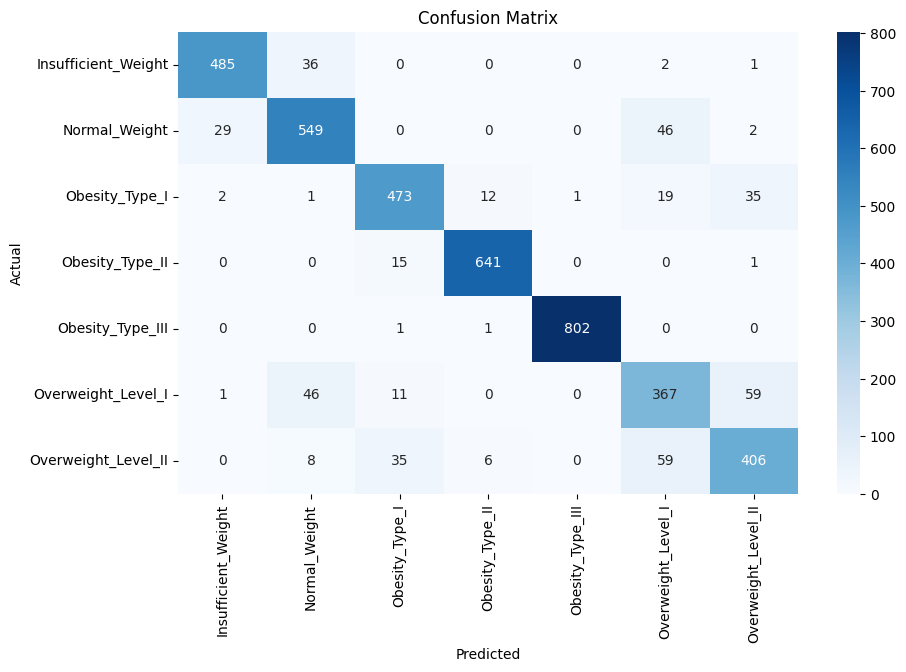

In [36]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Accuracy: 0.901252408477842
Classification Report:               precision    recall  f1-score   support

           0       0.93      0.93      0.93       524
           1       0.87      0.87      0.87       626
           2       0.89      0.87      0.88       543
           3       0.97      0.98      0.97       657
           4       1.00      1.00      1.00       804
           5       0.77      0.78      0.77       484
           6       0.80      0.81      0.81       514

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152

Confusion Matrix: [[488  33   0   0   0   1   2]
 [ 32 544   0   0   0  43   7]
 [  2   1 474  12   1  20  33]
 [  0   0  12 641   2   0   2]
 [  0   0   0   1 802   1   0]
 [  1  37  10   0   0 377  59]
 [  0   7  37   4   0  50 416]]


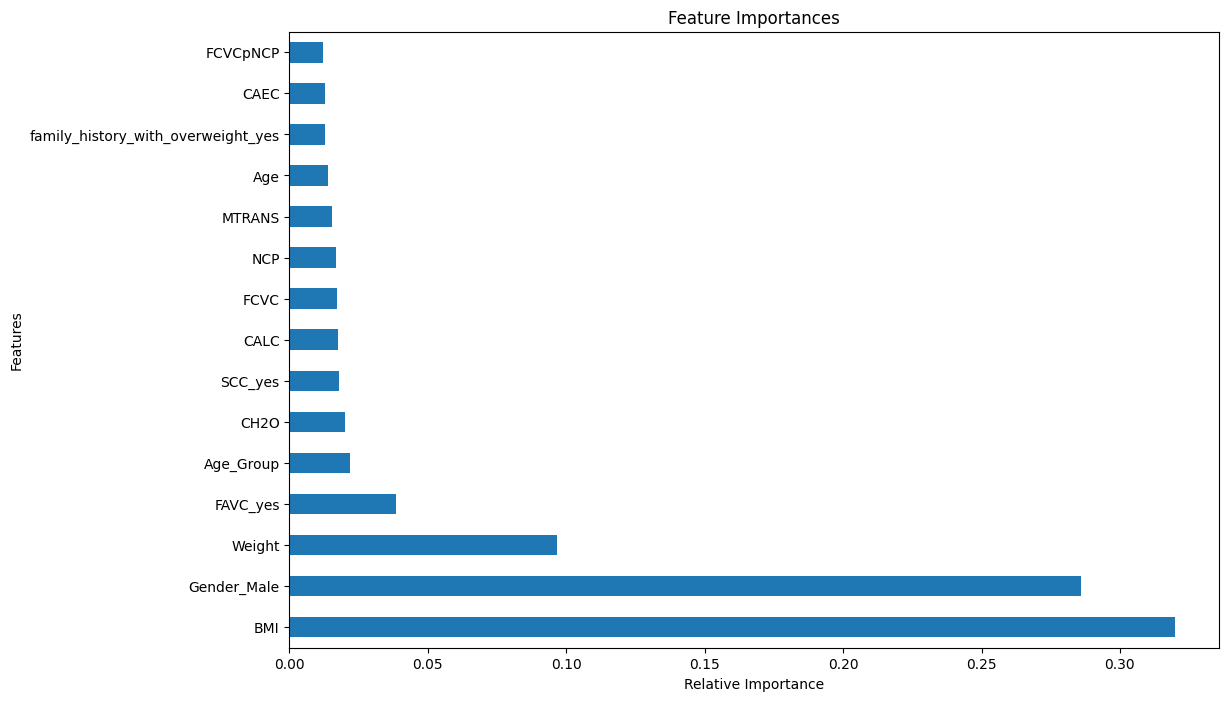

In [38]:
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

In [39]:
predictions = xgb.predict(test)
print(predictions)
predictions = encoder.inverse_transform(predictions)
print(predictions)

[3 5 4 ... 0 1 3]
['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']


In [40]:
submission_df=pd.DataFrame({'id':test_id,'NObeyesdad':predictions})

In [41]:
submission_df.to_csv('submission.csv', index=False)

In [42]:
submission_df

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight
